In [1]:
pip install mne mnelab pyxdf scikit-learn ipython

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement mne (from versions: none)
ERROR: No matching distribution found for mne


In [2]:
pip install mne

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     -------------------- ----------------- 30.7/57.6 kB 435.7 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 375.8 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 337.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB 1.4 MB/s eta 0:00:07
   ---------------------------------------- 0.0/8.3 MB 495.5 kB/s eta 0:00:17
   ---------------------------------------- 0.1/8.3 MB 563.7 kB/s eta 0:00:15
   ---------------------------------------- 0.1/8.3 MB 525.1 kB/s eta 0:00:16
   -----------------

Extracting EDF parameters from C:\Universidad\Señales\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Using matplotlib as 2D backend.


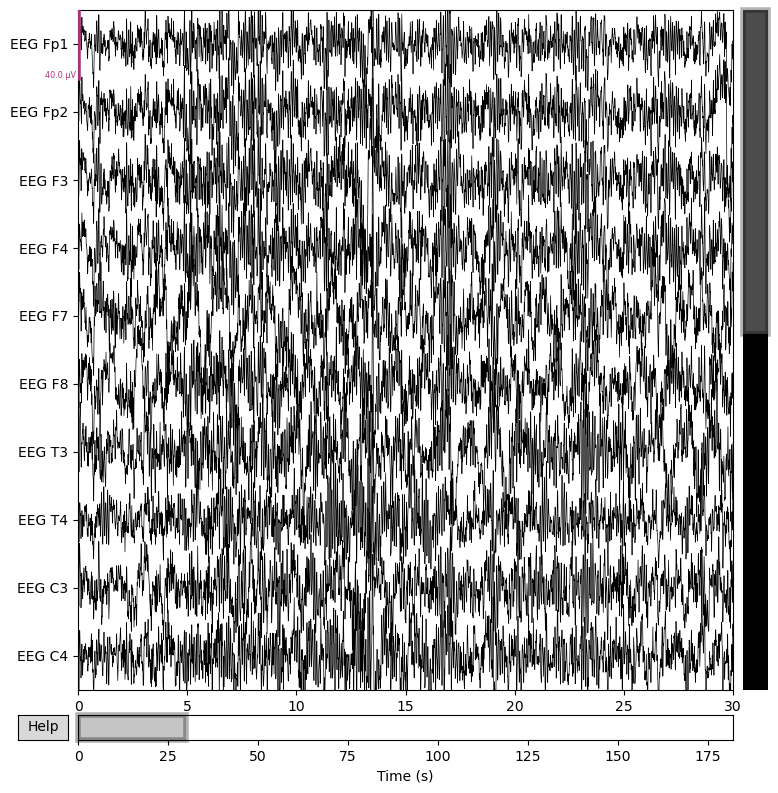

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 s)

Fitting ICA to data using 21 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 20 components
Fitting ICA took 2.5s.


C:\Users\nunsi\AppData\Local\Temp\ipykernel_47088\2651871179.py:29: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (18) and smallest (6.4e-11) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 19
  ica.fit(raw)


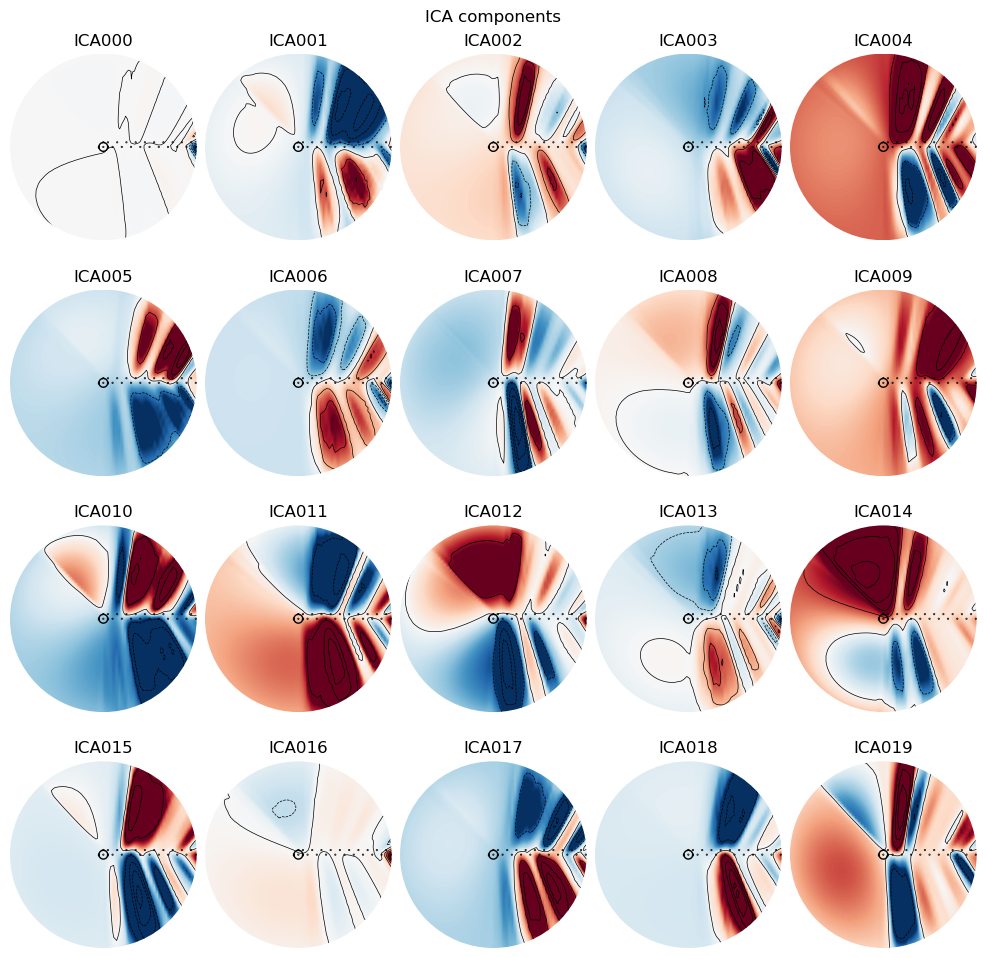

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 21 PCA components
Creating RawArray with float64 data, n_channels=21, n_times=91000
    Range : 0 ... 90999 =      0.000 ...   181.998 secs
Ready.


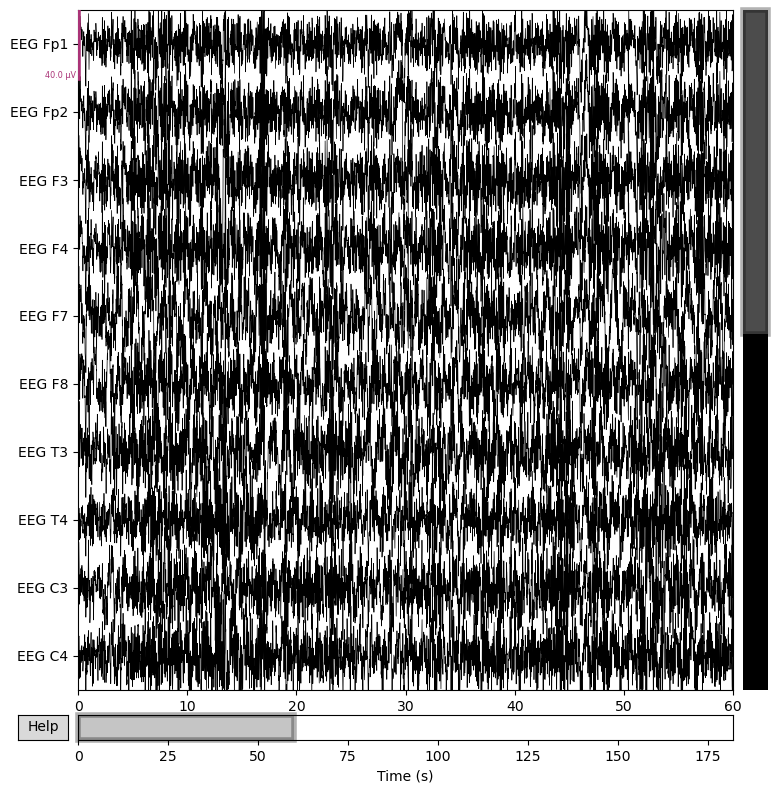

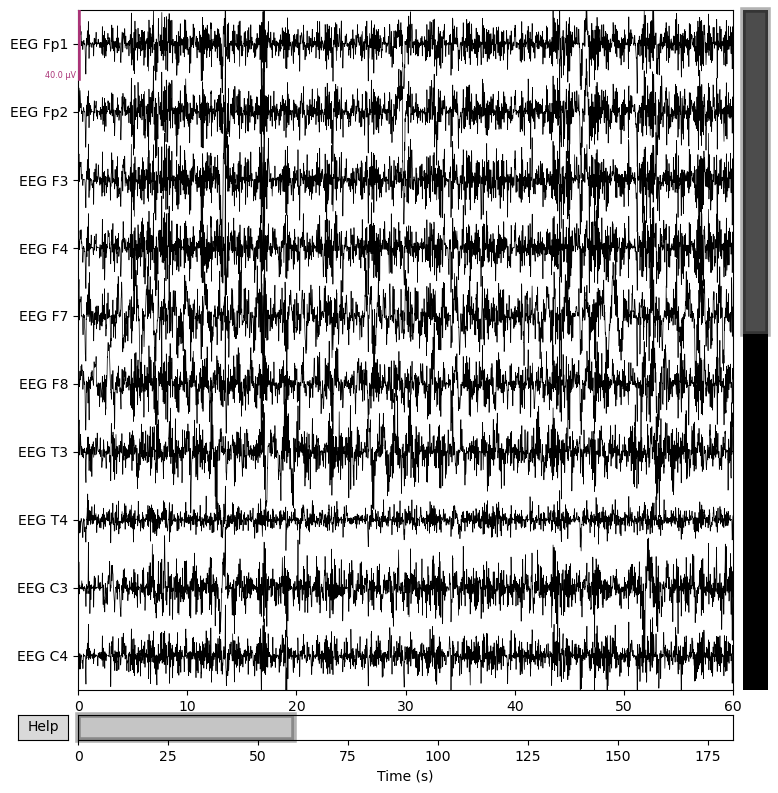

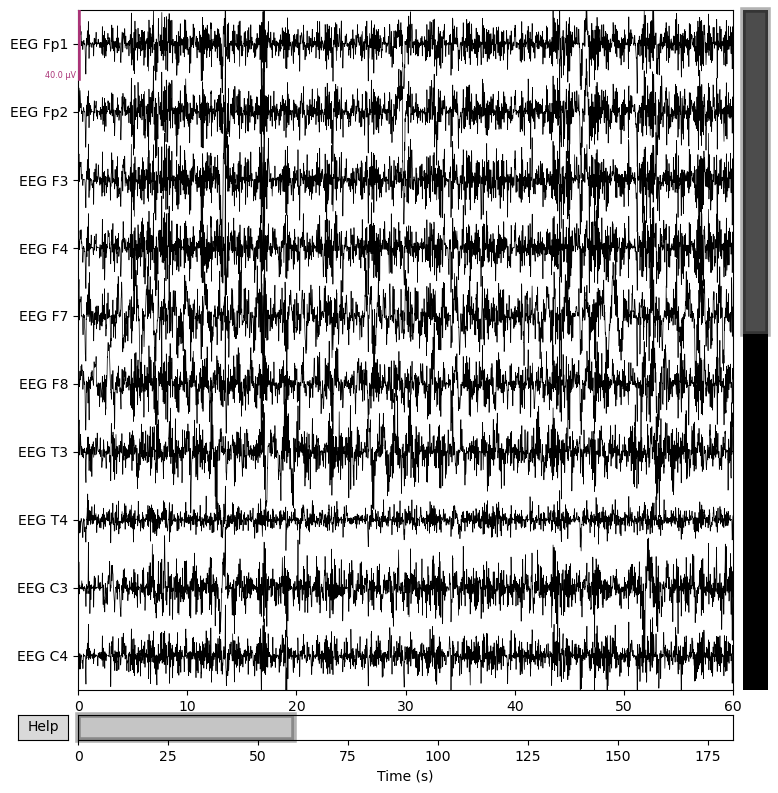

In [1]:
import mne
import numpy as np
import pywt
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from scipy.signal import welch

# Load the EDF file
file_path = 'C:/Universidad/Señales/Subject00_1.edf'
raw = mne.io.read_raw_edf(file_path, preload=True)

# Plot the raw data to see what it looks like
raw.plot(n_channels=10, duration=30, show=True)

# Apply bandpass filter (1-30 Hz)
raw.filter(1., 30., fir_design='firwin')

# Create a custom montage with approximate positions
channel_names = raw.ch_names
montage = mne.channels.make_dig_montage({
    ch_name: [0.1 * idx, 0.1 * (idx % 2), 0] for idx, ch_name in enumerate(channel_names)
}, coord_frame='head')

# Assign the custom montage to the raw data
raw.set_montage(montage)

# Apply ICA
ica = ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)

# Plot ICA components to identify artifacts
ica.plot_components()

# Manually exclude components related to artifacts (example indices)
ica.exclude = [0, 1]
raw_ica = raw.copy()
ica.apply(raw_ica)

# Updated wavelet denoising function
def wavelet_denoising(data, wavelet='db4', level=4, threshold_factor=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = (1/0.6745) * np.median(np.abs(coeffs[-level] - np.median(coeffs[-level])))
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs = [pywt.threshold(c, uthresh / threshold_factor, mode='soft') for c in coeffs]  # Fine-tune threshold
    return pywt.waverec(coeffs, wavelet)

# Apply wavelet denoising with fine-tuning
eeg_data_cleaned = raw_ica.get_data()
denoised_data = np.apply_along_axis(wavelet_denoising, 1, eeg_data_cleaned, threshold_factor=5)

# Create MNE Raw object from denoised data
info = raw_ica.info
raw_denoised = mne.io.RawArray(denoised_data, info)
# Visualize the raw and denoised signals
raw.plot(n_channels=10, duration=60, show=True, title="Raw EEG Data")
raw_denoised.plot(n_channels=10, duration=60, show=True, title="Denoised EEG Data")

Extracting EDF parameters from C:\Universidad\Señales\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


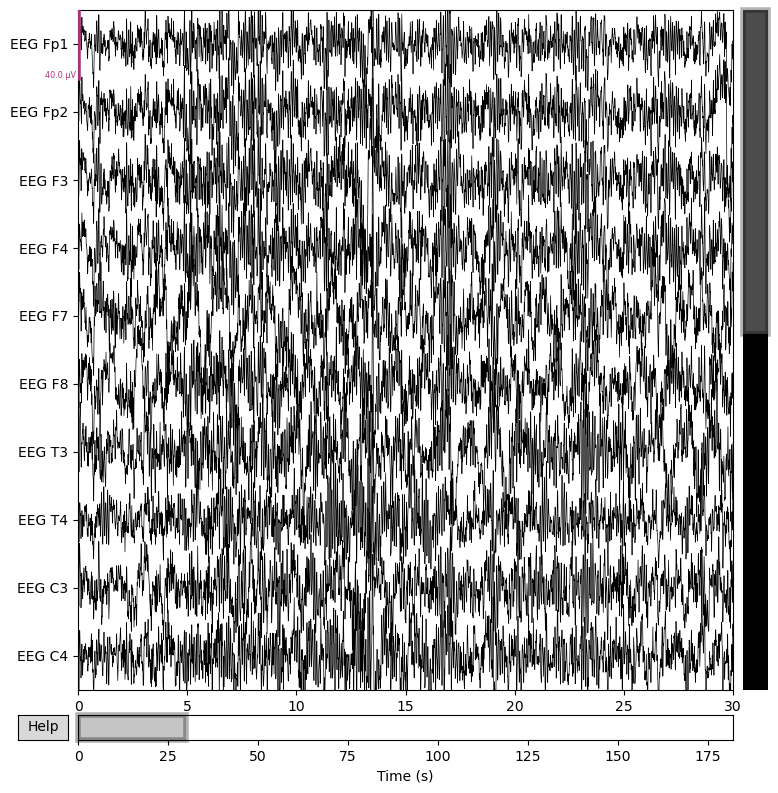

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 s)

Fitting ICA to data using 21 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.5s.


C:\Users\nunsi\AppData\Local\Temp\ipykernel_3636\1705436108.py:29: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (18) and smallest (6.4e-11) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 19
  ica.fit(raw)


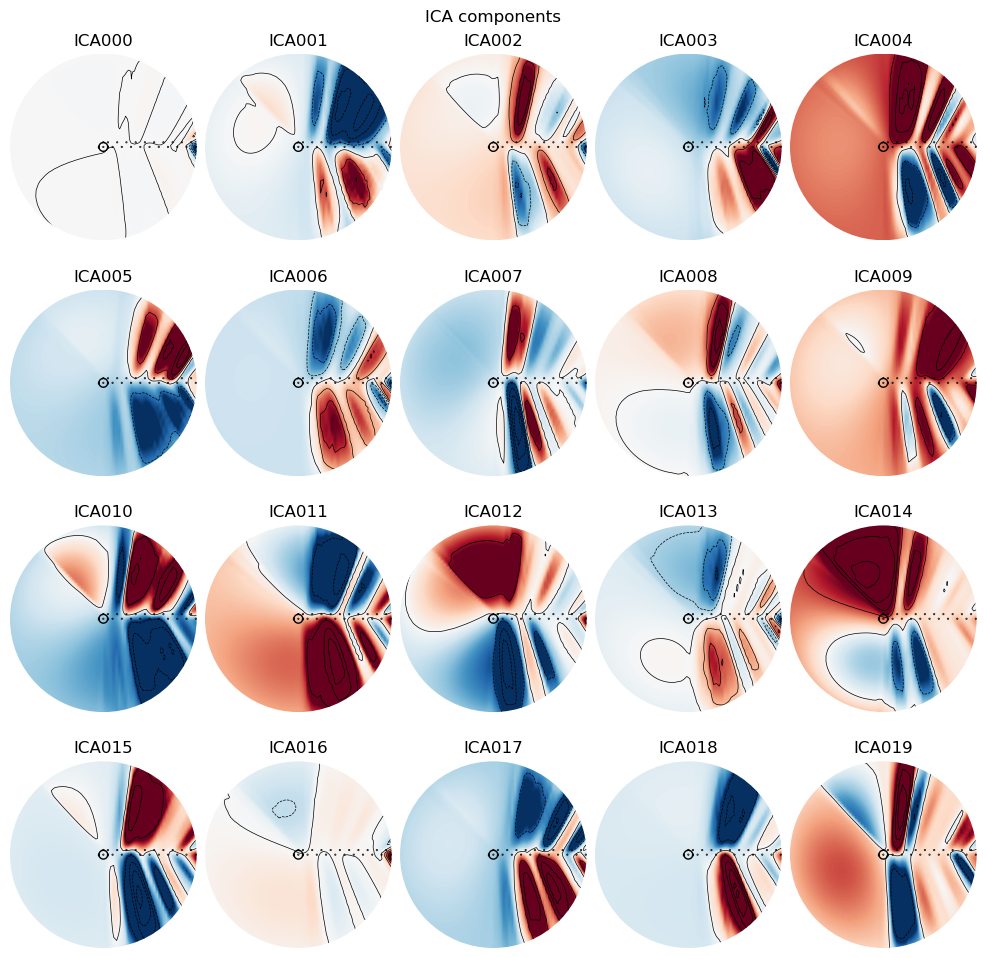

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 21 PCA components
Creating RawArray with float64 data, n_channels=21, n_times=91000
    Range : 0 ... 90999 =      0.000 ...   181.998 secs
Ready.


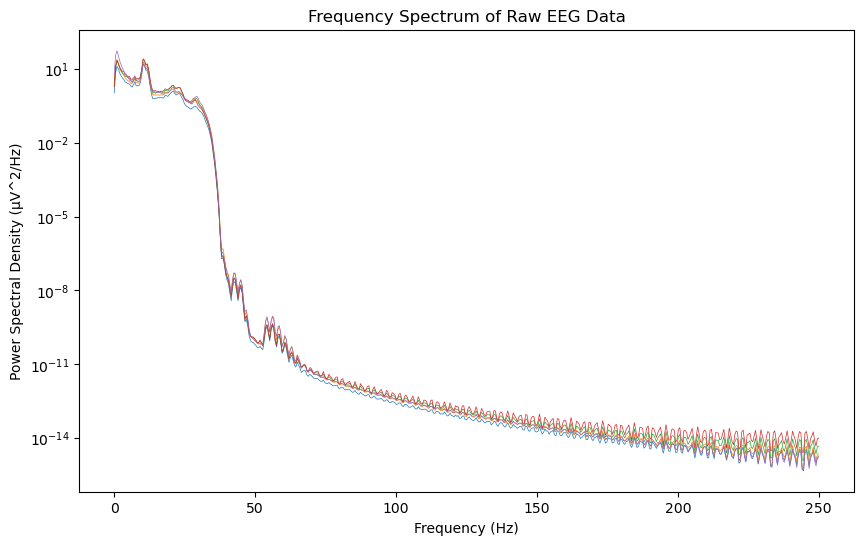

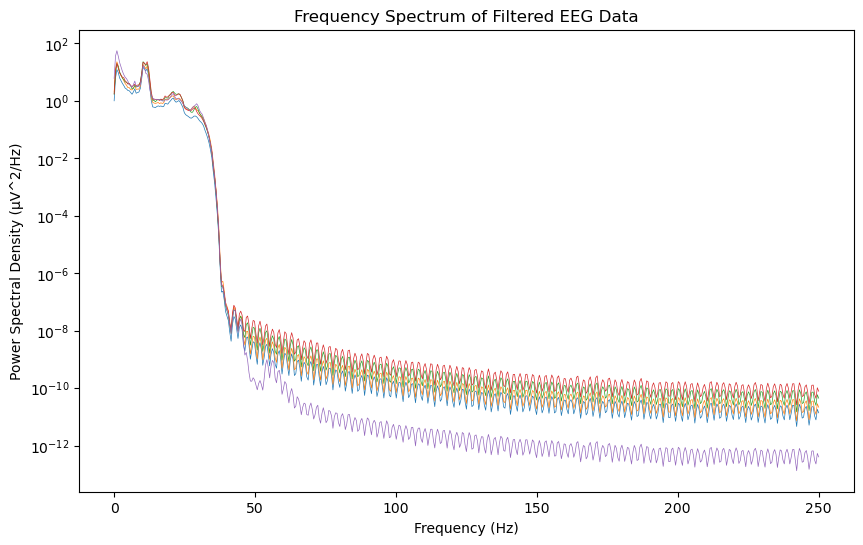

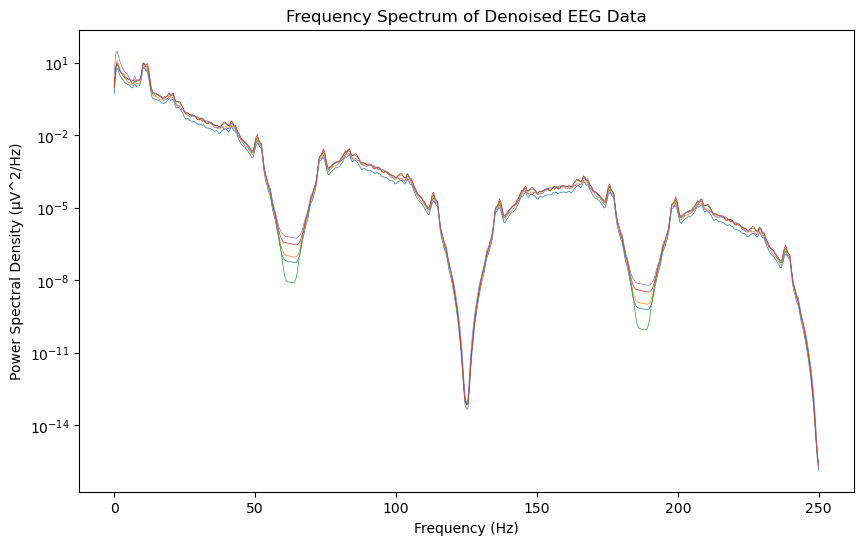

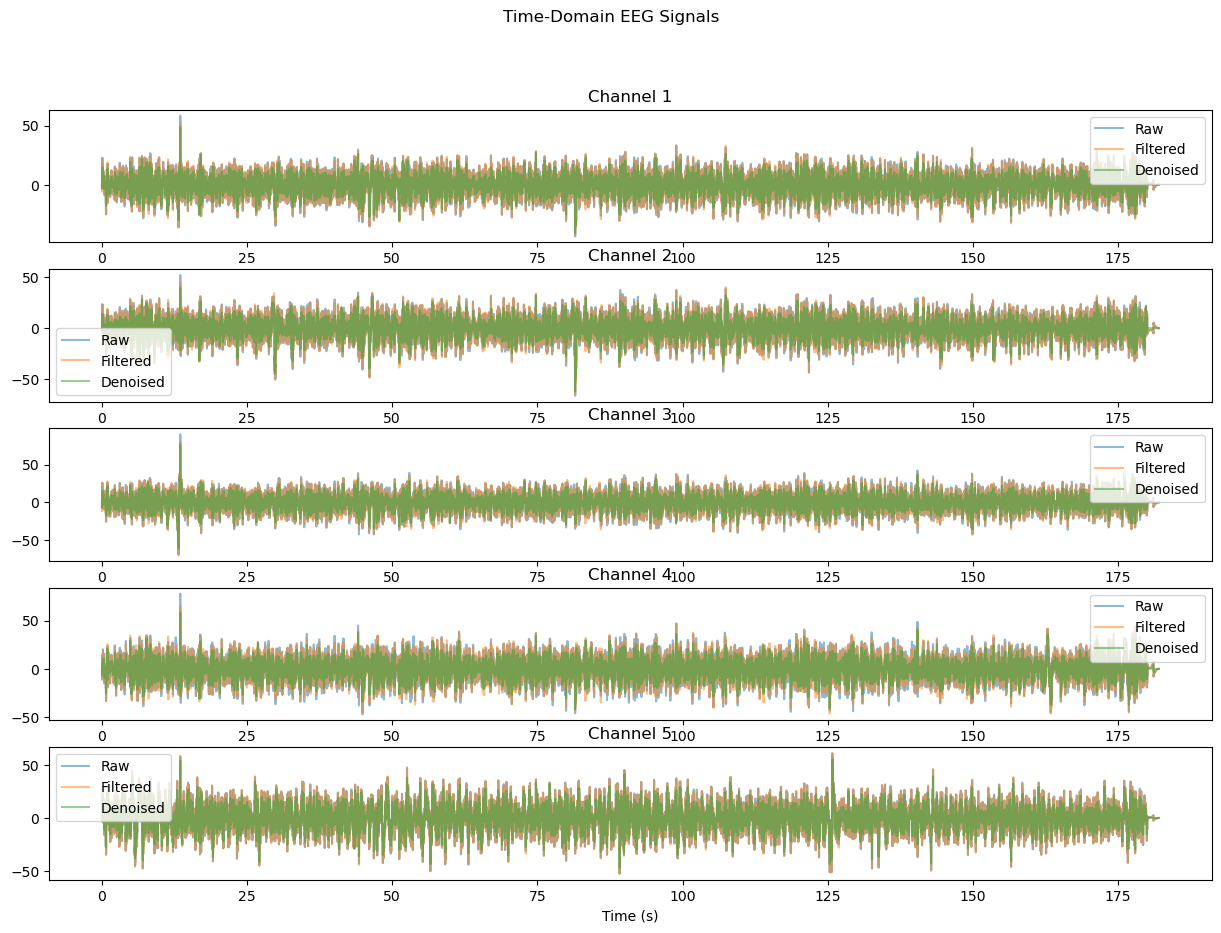

Raw Data Stats: -0.004010776288208761 29.35625033945553
Filtered Data Stats: -0.004010776290602485 12.073894578660992
Denoised Data Stats: -0.006310098601698988 8.61391356945809
EEG data processing and analysis complete.


In [33]:
import mne
import numpy as np
import pywt
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from scipy.signal import welch

# Load the EDF file
file_path = 'C:/Universidad/Señales/Subject00_1.edf'
raw = mne.io.read_raw_edf(file_path, preload=True)

# Plot the raw data to see what it looks like
raw.plot(n_channels=10, duration=30, show=True)

# Apply bandpass filter (1-30 Hz)
raw.filter(1., 30., fir_design='firwin')

# Create a custom montage with approximate positions
channel_names = raw.ch_names
montage = mne.channels.make_dig_montage({
    ch_name: [0.1 * idx, 0.1 * (idx % 2), 0] for idx, ch_name in enumerate(channel_names)
}, coord_frame='head')

# Assign the custom montage to the raw data
raw.set_montage(montage)

# Apply ICA
ica = ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)

# Plot ICA components to identify artifacts
ica.plot_components()

# Manually exclude components related to artifacts (example indices)
ica.exclude = [0, 1]
raw_ica = raw.copy()
ica.apply(raw_ica)

# Updated wavelet denoising function
def wavelet_denoising(data, wavelet='db4', level=4, threshold_factor=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = (1/0.6745) * np.median(np.abs(coeffs[-level] - np.median(coeffs[-level])))
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs = [pywt.threshold(c, uthresh / threshold_factor, mode='soft') for c in coeffs]  # Fine-tune threshold
    return pywt.waverec(coeffs, wavelet)

# Apply wavelet denoising with fine-tuning
eeg_data_cleaned = raw_ica.get_data()
denoised_data = np.apply_along_axis(wavelet_denoising, 1, eeg_data_cleaned, threshold_factor=5)

# Create MNE Raw object from denoised data
info = raw_ica.info
raw_denoised = mne.io.RawArray(denoised_data, info)

# Rescale data for better visualization
def rescale_data(data):
    return data * 1e6  # Scale to microvolts (µV)

raw_data = rescale_data(raw.get_data())
filtered_data = rescale_data(raw_ica.get_data())
denoised_data = rescale_data(denoised_data)

# Plot frequency spectrum
def plot_frequency_spectrum(data, sfreq, title):
    plt.figure(figsize=(10, 6))
    for i in range(min(data.shape[0], 5)):  # Plotting only first 5 channels for clarity
        f, Pxx = welch(data[i], sfreq, nperseg=1024)
        plt.semilogy(f, Pxx, lw=0.5)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (µV^2/Hz)')
    plt.show()

plot_frequency_spectrum(raw_data, raw.info['sfreq'], 'Frequency Spectrum of Raw EEG Data')
plot_frequency_spectrum(filtered_data, raw.info['sfreq'], 'Frequency Spectrum of Filtered EEG Data')
plot_frequency_spectrum(denoised_data, raw.info['sfreq'], 'Frequency Spectrum of Denoised EEG Data')

# Plot time-domain signals
def plot_time_domain_signals(raw_data, filtered_data, denoised_data, sfreq, title):
    time = np.linspace(0, raw_data.shape[1] / sfreq, raw_data.shape[1])
    plt.figure(figsize=(15, 10))
    for i in range(min(raw_data.shape[0], 5)):  # Plotting only first 5 channels for clarity
        plt.subplot(5, 1, i+1)
        plt.plot(time, raw_data[i], label='Raw', alpha=0.5)
        plt.plot(time, filtered_data[i], label='Filtered', alpha=0.5)
        plt.plot(time, denoised_data[i], label='Denoised', alpha=0.5)
        plt.title(f'Channel {i+1}')
        plt.legend()
    plt.suptitle(title)
    plt.xlabel('Time (s)')
    plt.show()

plot_time_domain_signals(raw_data, filtered_data, denoised_data, raw.info['sfreq'], 'Time-Domain EEG Signals')

# Print updated statistics
print("Raw Data Stats:", np.mean(raw_data), np.std(raw_data))
print("Filtered Data Stats:", np.mean(filtered_data), np.std(filtered_data))
print("Denoised Data Stats:", np.mean(denoised_data), np.std(denoised_data))

print("EEG data processing and analysis complete.")
